In [1]:
# --- [1] Imports and Config ---
import tensorflow as tf
from keras import layers, models, regularizers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, datetime, pathlib
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import joblib
import tensorflow as tf
# from tensorflow.keras import layers, models
import keras
from keras import layers
from keras import models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import datetime
# from tensorflow.keras import layers, models, regularizers
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import pathlib

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 20
DATA_DIR = r"C:\Users\ANISH BHUIN\OneDrive\Desktop\jbooks\PlantVillage"
MODEL_PATH = "potato_leaf_disease_hybrid1_model.keras"

In [3]:
def load_dataset(data_dir):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        seed=123,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )
    return dataset

dataset = load_dataset(DATA_DIR)
class_names = dataset.class_names
n_classes = len(class_names)

Found 2152 files belonging to 3 classes.


In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000, seed=12):
    assert (train_split + val_split + test_split) == 1.0
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_size, seed=seed, reshuffle_each_iteration=False)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [5]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

In [7]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# --- [6] Extract Features for LightGBM ---
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
feature_extractor = EfficientNetV2B3(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
feature_extractor.trainable = False

In [9]:
def extract_features(dataset):
    features, labels = [], []
    for batch, label in dataset.unbatch().batch(32):
        batch = preprocess_input(batch)
        batch_features = feature_extractor(batch)
        features.append(batch_features.numpy())
        labels.append(label.numpy())
    return np.concatenate(features), np.concatenate(labels)

X_train, y_train = extract_features(train_ds)
X_val, y_val = extract_features(val_ds)
X_test, y_test = extract_features(test_ds)

In [10]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dict for LightGBM
weight_dict = {i: w for i, w in enumerate(class_weights)}

In [11]:
# --- [7] Train LightGBM ---
from lightgbm import early_stopping, log_evaluation

model_lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=n_classes,
    class_weight=weight_dict,
    n_estimators=200,
    learning_rate=0.05
)

model_lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=10)  # print metrics every 10 iterations
    ]
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 1536
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 10 rounds
[10]	valid_0's multi_logloss: 0.694345
[20]	valid_0's multi_logloss: 0.488964
[30]	valid_0's multi_logloss: 0.372176
[40]	valid_0's multi_logloss: 0.297903
[50]	valid_0's multi_logloss: 0.24057
[60]	valid_0's multi_logloss: 0.196998
[70]	valid_0's multi_logloss: 0.162174
[80]	valid_0's multi_logloss: 0.13873
[90]	valid_0's multi_logloss: 0.120446
[100]	valid_0's multi_logloss: 0.102804
[110]	valid_0's multi_logloss: 0.0919456
[120]	valid_0's multi_logloss: 0.0817729
[130]	valid_0'

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,"{0: np.float64(0.7291139240506329), 1: np.float64(0.7128712871287128), 2: np.float64(4.430769230769231)}"
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


                       precision    recall  f1-score   support

Potato___Early_blight       0.98      0.98      0.98       126
 Potato___Late_blight       0.96      0.98      0.97       112
     Potato___healthy       1.00      0.78      0.88        18

             accuracy                           0.97       256
            macro avg       0.98      0.91      0.94       256
         weighted avg       0.97      0.97      0.97       256



C:\Users\ANISH BHUIN\OneDrive\Desktop\jbooks\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


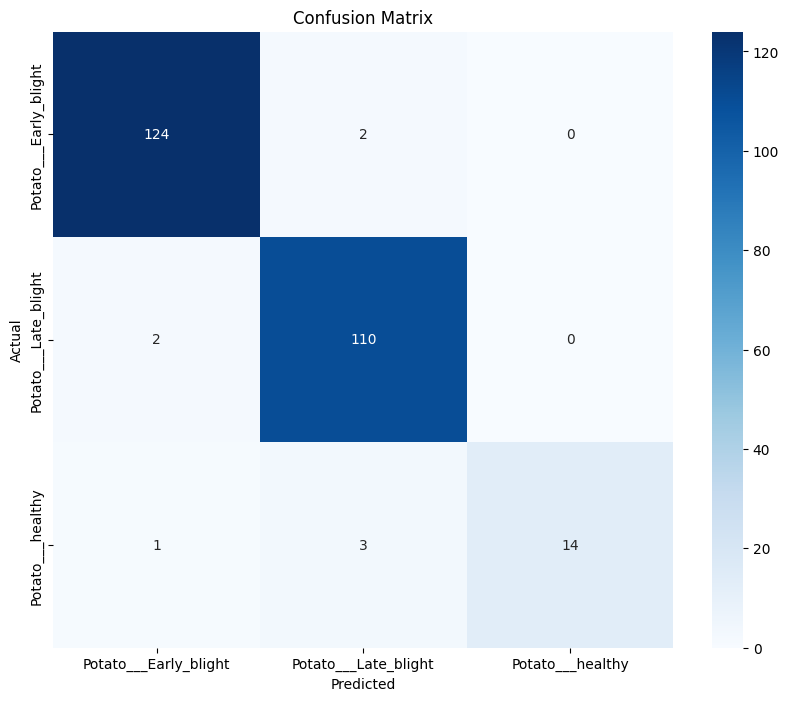

In [12]:
# --- [8] Evaluate Model ---
y_pred = model_lgbm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
joblib.dump(model_lgbm, "lgbm_plant_disease_model.pkl")

['lgbm_plant_disease_model.pkl']